In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from wj_autoencoders import Autoencoder, VariationalAutoencoder

In [2]:
seed = 37

np.random.seed(seed)
torch.manual_seed(seed)

# Set device (with seed)
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(seed)
elif torch.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
    
print(f"Using device {device} with manual seed {seed}.")

Using device mps with manual seed 37.


In [3]:
df = pd.read_csv('lish_moa_annotated.csv.gz', low_memory=False)

# Separate treated samples from control samples
treated_df = df[df['cp_type'] == 'trt_cp'].reset_index(drop=True)
control_df = df[df['cp_type'] == 'ctrl_vehicle'].reset_index(drop=True)

# Extract gene expression and cell viability features
gene_cols = [col for col in df.columns if col.startswith('g-')]
cell_cols = [col for col in df.columns if col.startswith('c-')]
feature_cols = gene_cols + cell_cols
print(f"Total features: {len(feature_cols)} (Genes: {len(gene_cols)}, Cells: {len(cell_cols)})")

# Extract MoA columns (excluding metadata and feature columns)
metadata_cols = ['sig_id', 'drug_id', 'training', 'cp_type', 'cp_time', 'cp_dose']
moa_cols = [col for col in df.columns 
            if not col.startswith('g-') and 
               not col.startswith('c-') and 
               col not in metadata_cols]
print(f"Total MoA labels: {len(moa_cols)}")

Total features: 872 (Genes: 772, Cells: 100)
Total MoA labels: 608


In [4]:
# Extract features and labels from treated samples
X = treated_df[feature_cols].values
y = treated_df[moa_cols].values

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_train_tensor = torch.FloatTensor(y_train)
y_val_tensor = torch.FloatTensor(y_val)

In [5]:
# Create DataLoaders
batch_size = 1024 * 8
num_workers = 10 # Set to number of performance cores on your apple silicon

train_dataset = TensorDataset(X_train_tensor, X_train_tensor)  # Autoencoder input = output
val_dataset = TensorDataset(X_val_tensor, X_val_tensor)
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    num_workers=num_workers, 
    persistent_workers=True, 
    shuffle=True
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    num_workers=num_workers, 
    persistent_workers=True
)

In [8]:
# Set model parameters
input_dim = len(feature_cols)
hidden_dims = [512, 256, 128]  # Decreasing hidden layer sizes
latent_dim = 64  # Bottleneck dimension size

# Choose variational or standard autoencoder
use_vae = True  # Set to False for standard autoencoder

if use_vae:
    state_dict_filename = "best_vae_autoencoder_model.pt"
    model = VariationalAutoencoder(input_dim, hidden_dims, latent_dim)
    print("Using Variational Autoencoder")
else:
    state_dict_filename = "best_simple_autoencoder_model.pt"
    model = Autoencoder(input_dim, hidden_dims, latent_dim)
    print("Using Standard Autoencoder")

model.to(device)

Using Variational Autoencoder


VariationalAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=872, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
  )
  (fc_mu): Linear(in_features=128, out_features=64, bias=True)
  (fc_log_var): Linear(in_features=128, out_features=64, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
 

In [9]:
# Load the best model
model.load_state_dict(torch.load(state_dict_filename))

# Generate embeddings using the trained autoencoder
def get_embeddings(model, data_loader, device, use_vae):
    model.eval()
    embeddings = []
    
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(device)
            
            if use_vae:
                mu, _ = model.encode(data)
                embeddings.append(mu.cpu().numpy())
            else:
                encoded = model.get_latent(data)
                embeddings.append(encoded.cpu().numpy())
    
    return np.vstack(embeddings)

# Get embeddings for train and validation sets
train_embeddings = get_embeddings(model, train_loader, device, use_vae)
val_embeddings = get_embeddings(model, val_loader, device, use_vae)

print(f"Train embeddings shape: {train_embeddings.shape}")
print(f"Validation embeddings shape: {val_embeddings.shape}")

Train embeddings shape: (20457, 64)
Validation embeddings shape: (5115, 64)


In [10]:
# Compare with PCA
# Apply PCA with the same latent dimension
pca = PCA(n_components=latent_dim)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

# Function to evaluate reconstruction quality
def evaluate_reconstruction(original, embeddings, decoder=None, is_pca=False):
    if is_pca:
        # For PCA, reconstruct by inverse transform
        reconstructed = pca.inverse_transform(embeddings)
    else:
        # For autoencoder, use the decoder
        with torch.no_grad():
            tensor_embeddings = torch.FloatTensor(embeddings).to(device)
            if use_vae:
                reconstructed = decoder(tensor_embeddings).cpu().numpy()
            else:
                reconstructed = decoder(tensor_embeddings).cpu().numpy()
    
    # Calculate MSE
    mse = mean_squared_error(original, reconstructed)
    return mse, reconstructed

In [11]:
# Evaluate PCA reconstruction
pca_mse_train, X_train_pca_reconstructed = evaluate_reconstruction(X_train_scaled, X_train_pca, is_pca=True)
pca_mse_val, X_val_pca_reconstructed = evaluate_reconstruction(X_val_scaled, X_val_pca, is_pca=True)

# Evaluate autoencoder reconstruction
if use_vae:
    ae_mse_train, X_train_ae_reconstructed = evaluate_reconstruction(
        X_train_scaled, train_embeddings, decoder=model.decode, is_pca=False)
    ae_mse_val, X_val_ae_reconstructed = evaluate_reconstruction(
        X_val_scaled, val_embeddings, decoder=model.decode, is_pca=False)
else:
    ae_mse_train, X_train_ae_reconstructed = evaluate_reconstruction(
        X_train_scaled, train_embeddings, decoder=model.decoder, is_pca=False)
    ae_mse_val, X_val_ae_reconstructed = evaluate_reconstruction(
        X_val_scaled, val_embeddings, decoder=model.decoder, is_pca=False)

print(f"PCA Reconstruction MSE - Train: {pca_mse_train:.6f}, Val: {pca_mse_val:.6f}")
print(f"Autoencoder Reconstruction MSE - Train: {ae_mse_train:.6f}, Val: {ae_mse_val:.6f}")

PCA Reconstruction MSE - Train: 0.331386, Val: 0.336775
Autoencoder Reconstruction MSE - Train: 1.541607, Val: 0.427572


Number of samples with at least one MOA: 14607
Embeddings visualization saved to pca_embeddings.png and autoencoder_embeddings.png


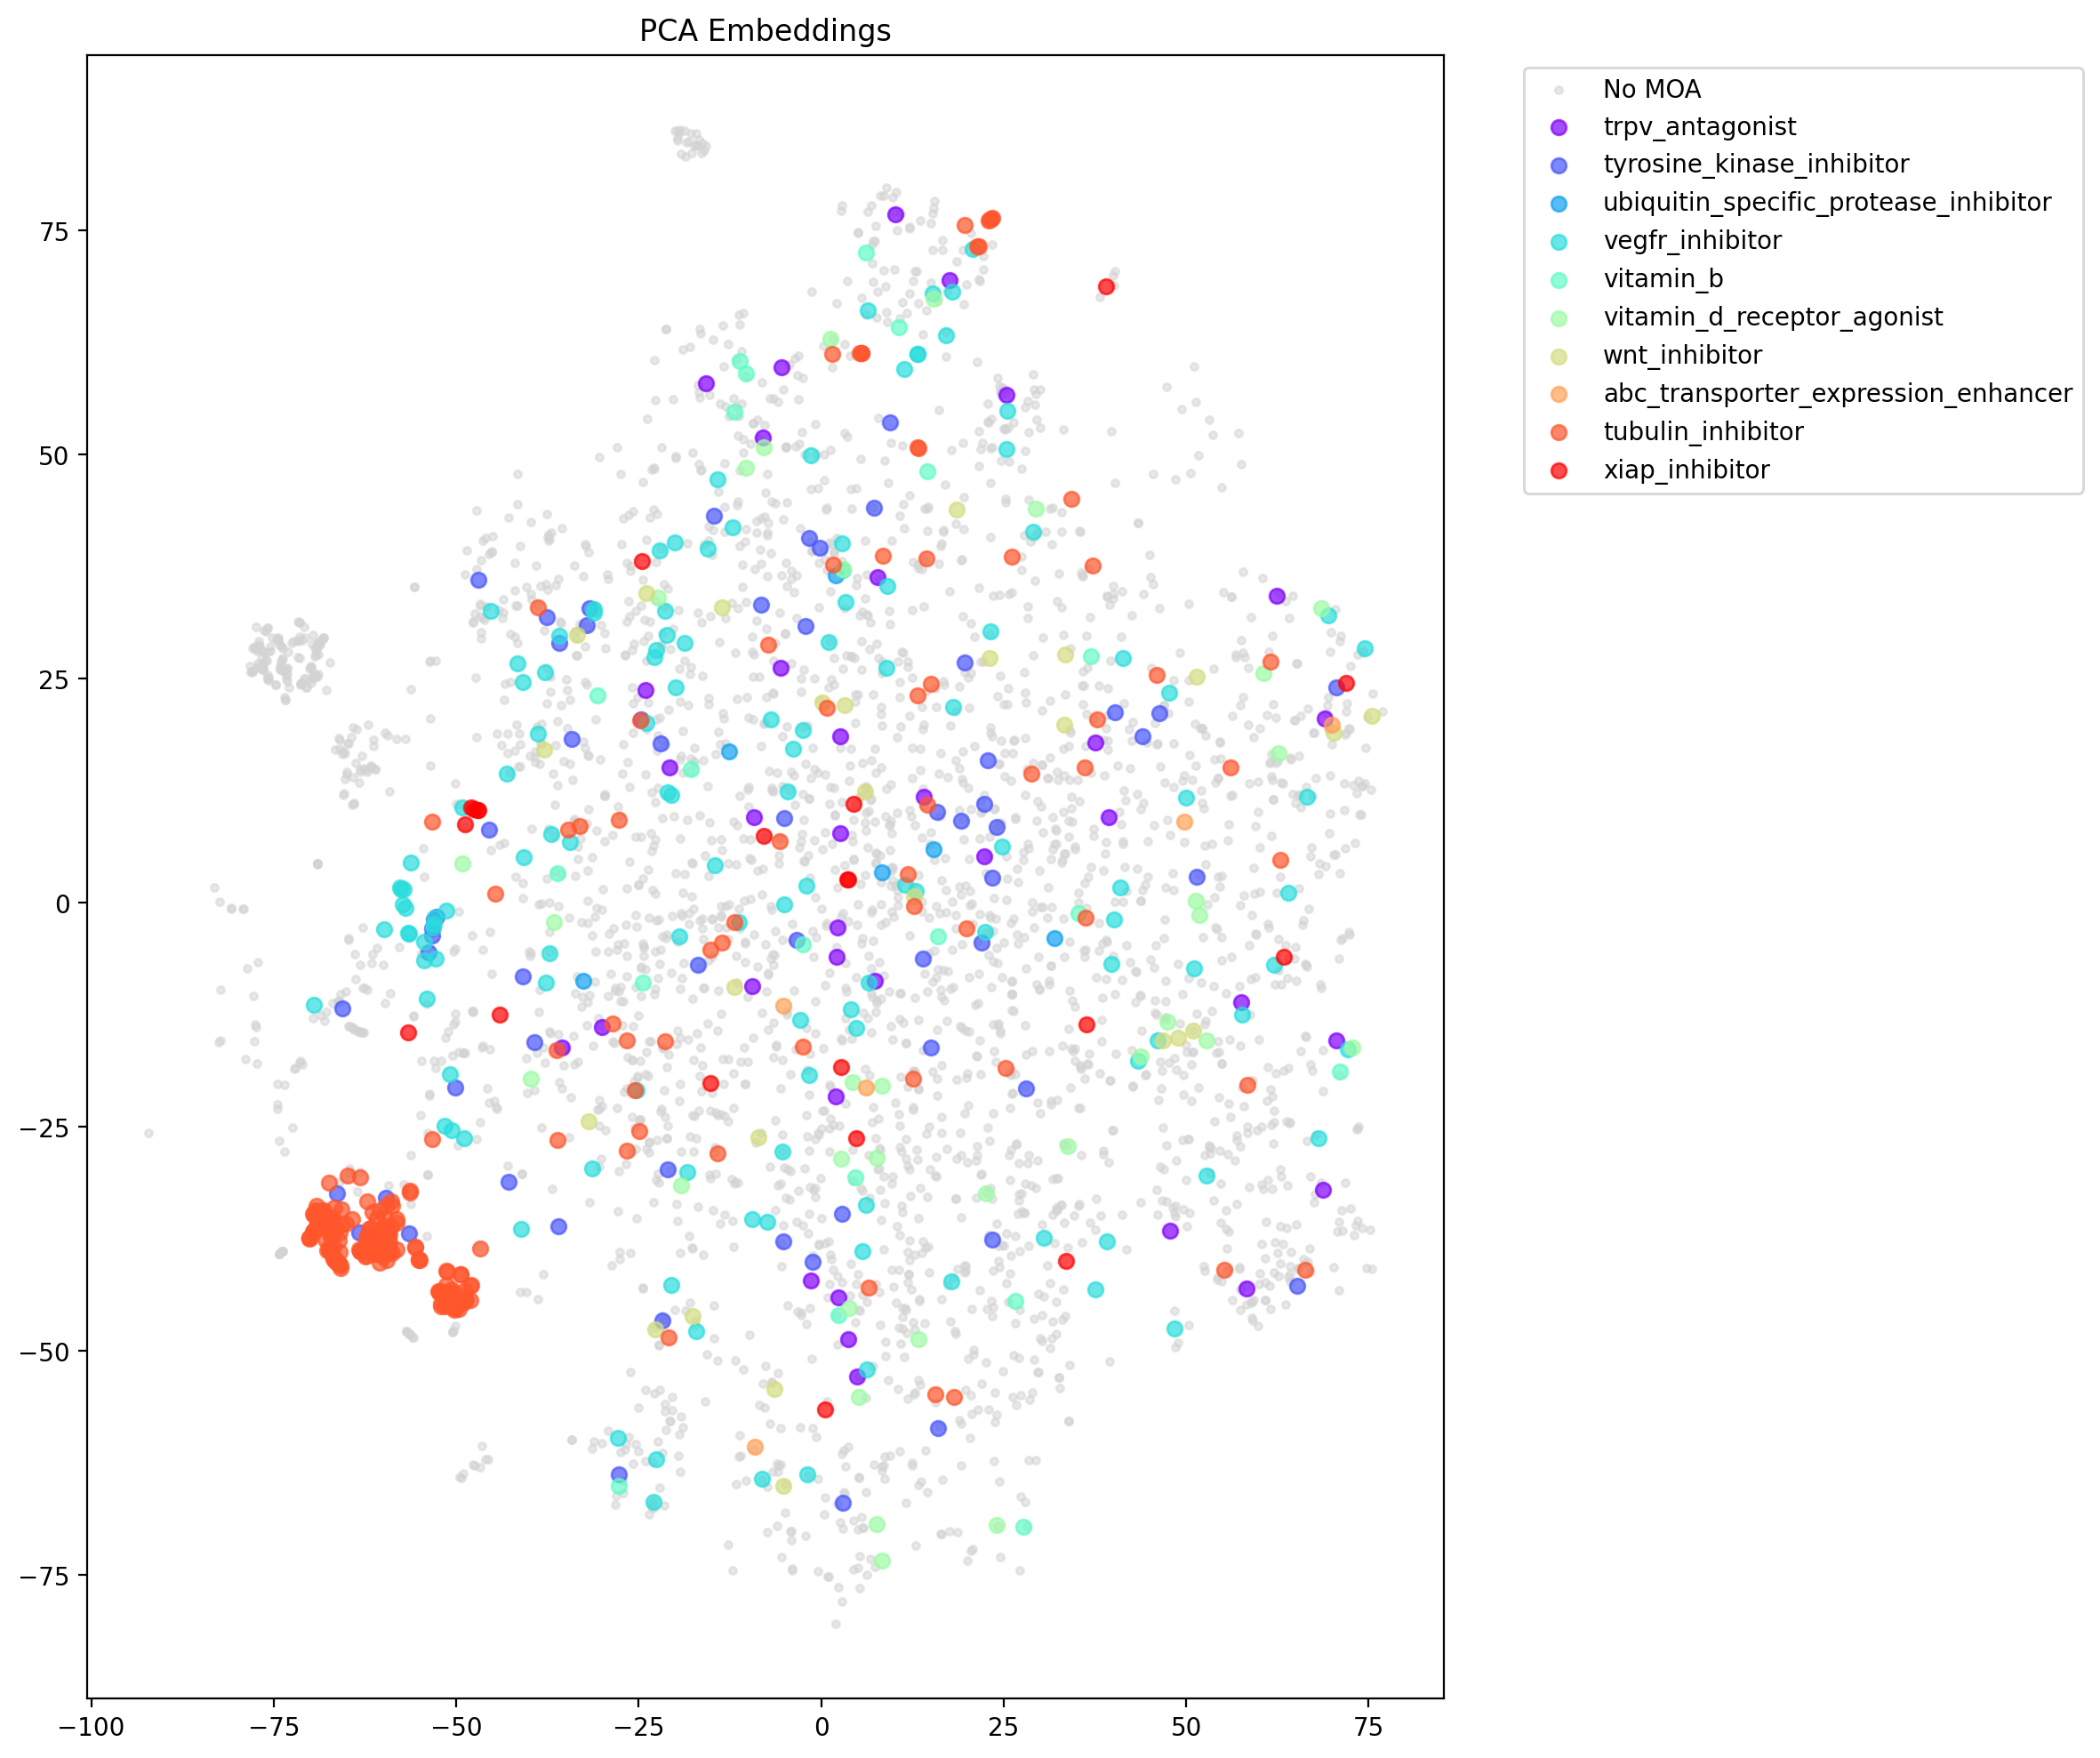

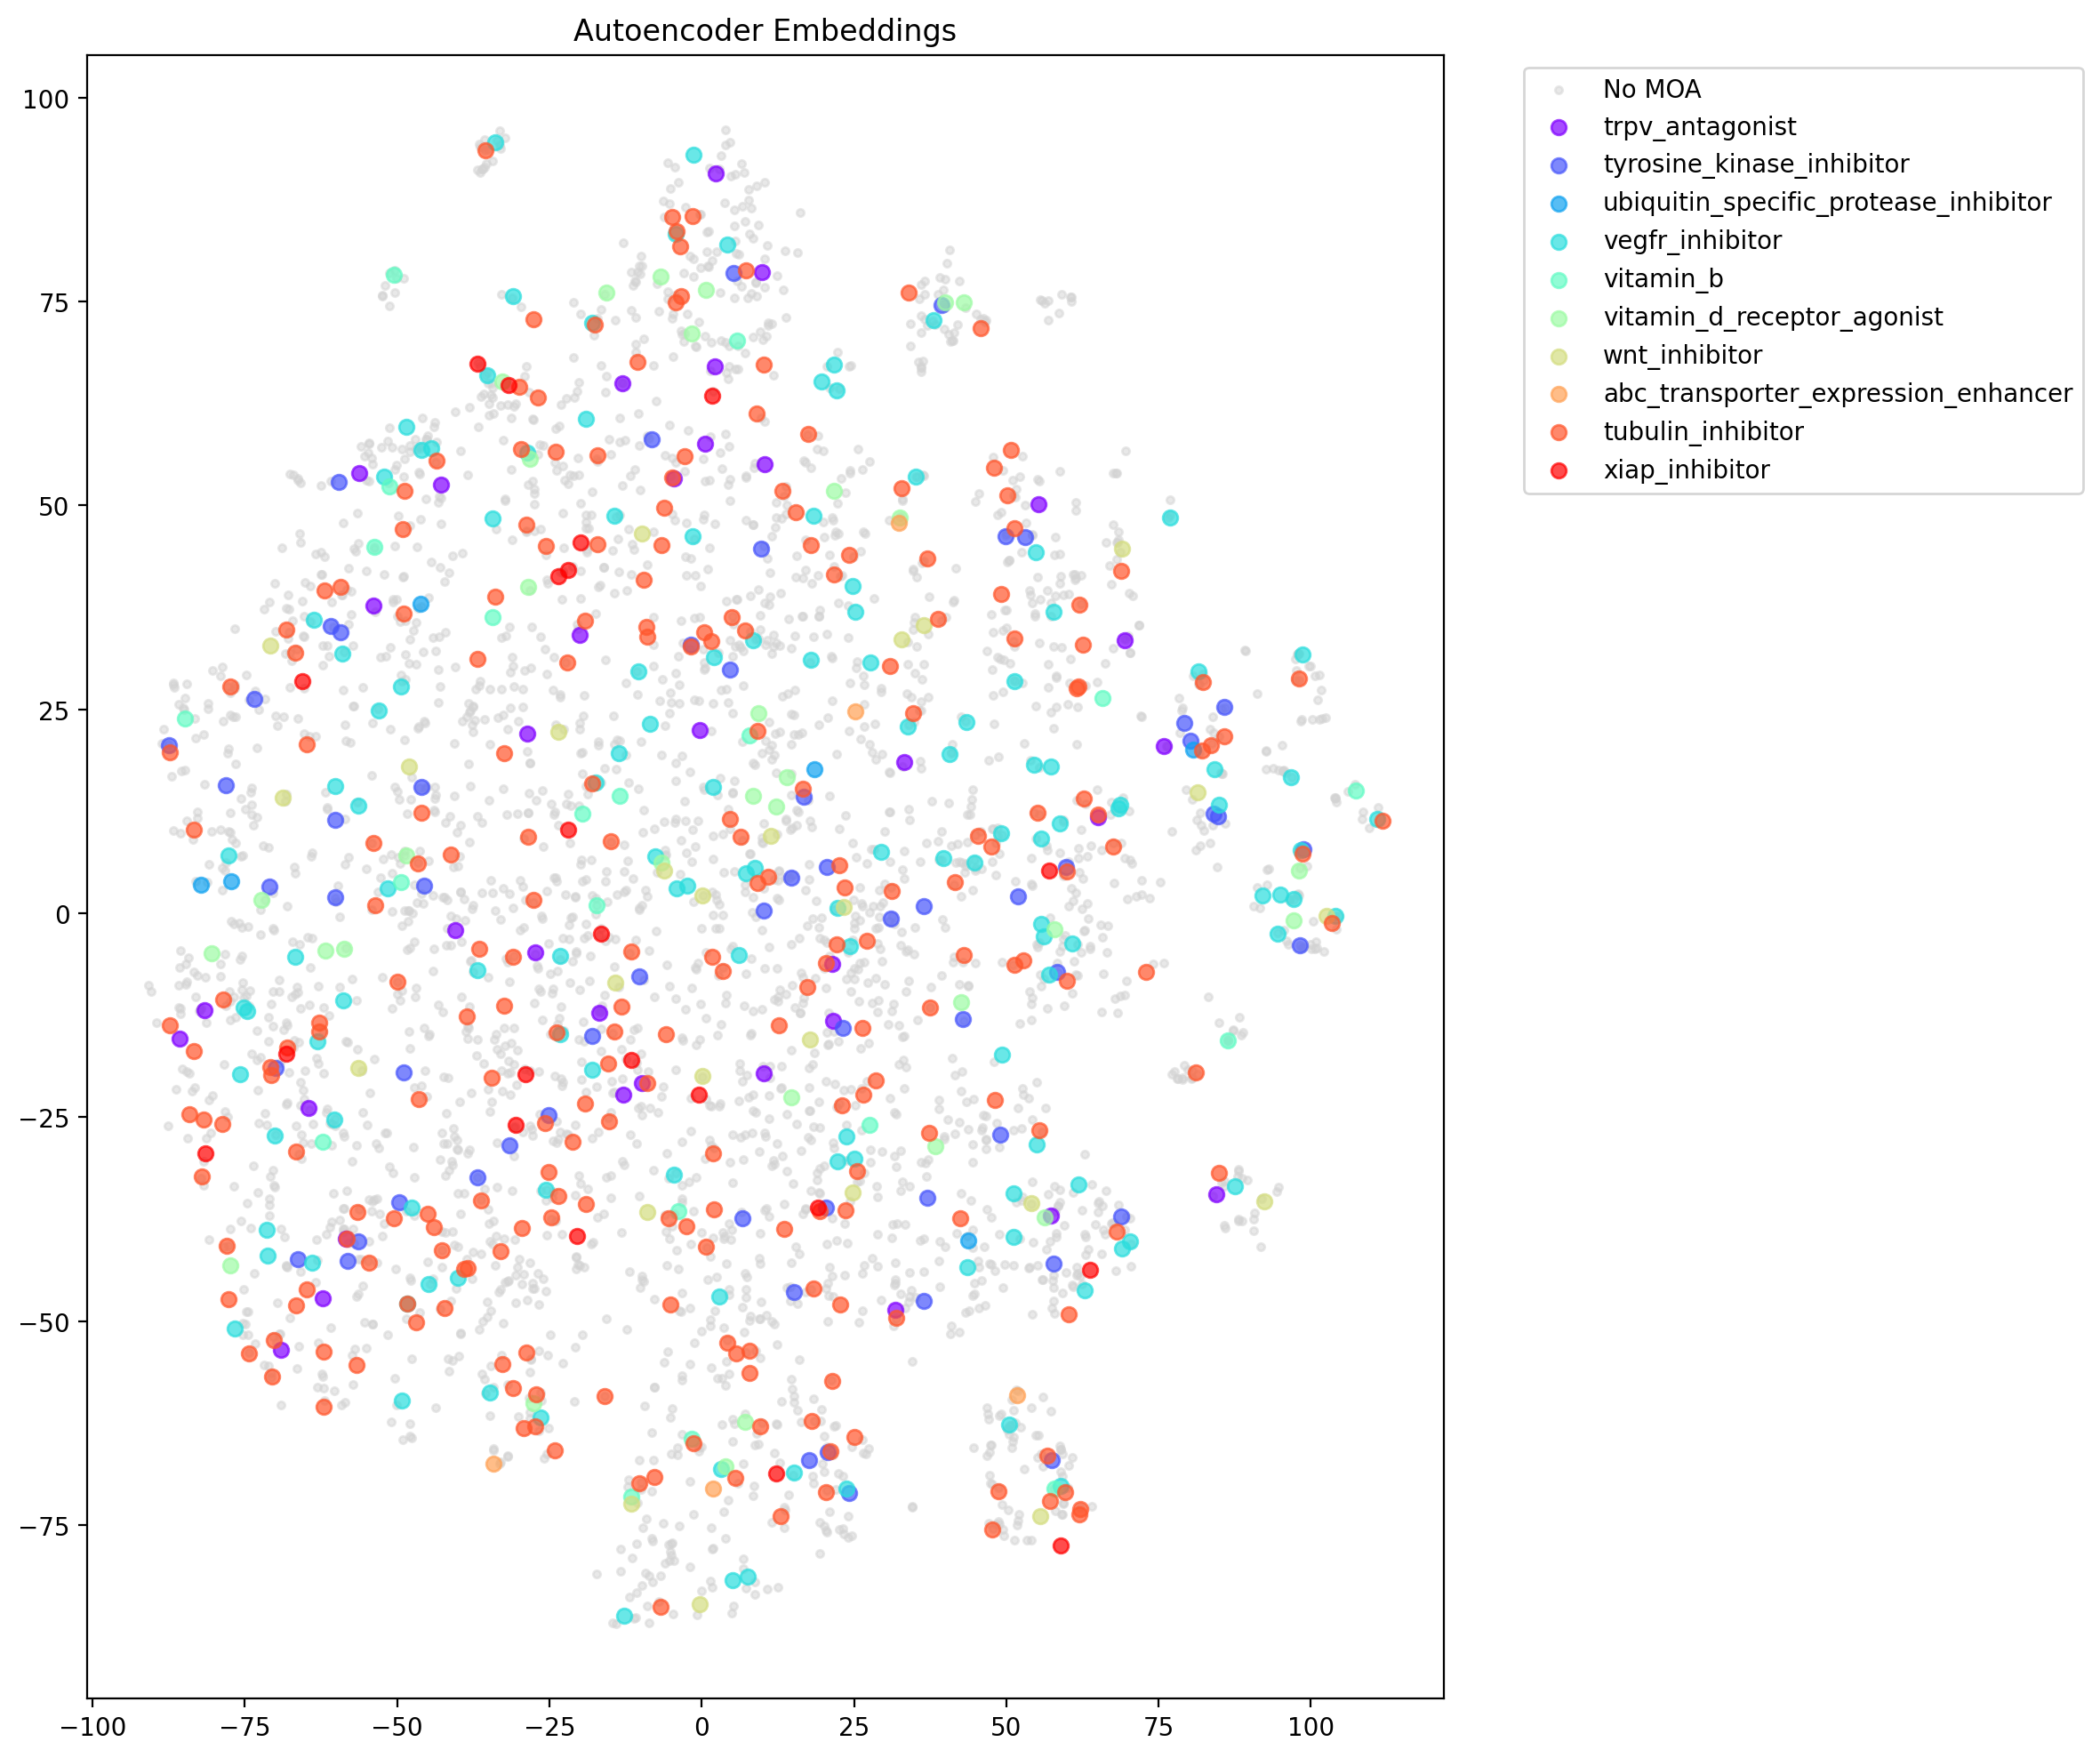

In [12]:
# Visualize the embeddings
# First, get drugs with at least one MOA
has_moa = np.sum(y_train, axis=1) > 0
print(f"Number of samples with at least one MOA: {np.sum(has_moa)}")

# Filter top MOAs for visualization
top_moa_counts = np.sum(y_train, axis=0)
top_moa_indices = np.argsort(top_moa_counts)[-10:]  # Top 10 MOAs
top_moa_names = [moa_cols[i] for i in top_moa_indices]

# Function to create a 2D visualization using t-SNE
def plot_tsne(embeddings, labels, title, top_moa_indices):
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    # Create a plot
    plt.figure(figsize=(12, 10))
    
    # Plot samples without MOA
    mask_no_moa = np.sum(labels, axis=1) == 0
    plt.scatter(embeddings_2d[mask_no_moa, 0], embeddings_2d[mask_no_moa, 1], 
                c='lightgray', marker='.', alpha=0.5, label='No MOA')
    
    # Plot samples with top MOAs
    colors = plt.cm.rainbow(np.linspace(0, 1, len(top_moa_indices)))
    for i, moa_idx in enumerate(top_moa_indices):
        mask = labels[:, moa_idx] > 0
        plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], 
                    c=[colors[i]], marker='o', alpha=0.7, label=moa_cols[moa_idx])
    
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    return plt


# Visualize PCA vs Autoencoder embeddings
pca_plt = plot_tsne(X_train_pca, y_train, 'PCA Embeddings', top_moa_indices)
pca_plt.savefig('pca_embeddings.png')

ae_plt = plot_tsne(train_embeddings, y_train, 'Autoencoder Embeddings', top_moa_indices)
ae_plt.savefig('autoencoder_embeddings.png')

print("Embeddings visualization saved to pca_embeddings.png and autoencoder_embeddings.png")


In [13]:
# Evaluate separation of MOAs in the latent space
def evaluate_moa_separation(embeddings, labels):
    """Calculate silhouette score and other metrics to evaluate cluster separation"""
    from sklearn.metrics import silhouette_score, calinski_harabasz_score
    
    # Create binary labels for each MOA
    moa_silhouette_scores = []
    moa_ch_scores = []
    
    for moa_idx in top_moa_indices:
        mask = labels[:, moa_idx] > 0
        if sum(mask) > 10:  # Need enough samples
            # Create binary labels (1 for this MOA, 0 for others)
            binary_labels = labels[:, moa_idx] > 0
            
            try:
                # Calculate silhouette score
                sil_score = silhouette_score(embeddings, binary_labels)
                moa_silhouette_scores.append((moa_cols[moa_idx], sil_score))
                
                # Calculate Calinski-Harabasz score
                ch_score = calinski_harabasz_score(embeddings, binary_labels)
                moa_ch_scores.append((moa_cols[moa_idx], ch_score))
            except:
                continue
    
    return moa_silhouette_scores, moa_ch_scores

# Evaluate PCA vs Autoencoder for MOA separation
pca_sil_scores, pca_ch_scores = evaluate_moa_separation(X_train_pca, y_train)
ae_sil_scores, ae_ch_scores = evaluate_moa_separation(train_embeddings, y_train)

In [14]:
print("\nSilhouette Scores for MOA Separation:")
print("PCA:", pca_sil_scores)
print("Autoencoder:", ae_sil_scores)

print("\nCalinski-Harabasz Scores for MOA Separation:")
print("PCA:", pca_ch_scores)
print("Autoencoder:", ae_ch_scores)

# Summary of results
print("\nSummary:")
print(f"Autoencoder latent dimension: {latent_dim}")
print(f"PCA explained variance ratio: {sum(pca.explained_variance_ratio_):.4f}")
print(f"PCA reconstruction MSE: {pca_mse_val:.6f}")
print(f"Autoencoder reconstruction MSE: {ae_mse_val:.6f}")
print(f"Average PCA silhouette score: {np.mean([s[1] for s in pca_sil_scores]):.4f}")
print(f"Average AE silhouette score: {np.mean([s[1] for s in ae_sil_scores]):.4f}")
print(f"Average PCA Calinski-Harabasz score: {np.mean([s[1] for s in pca_ch_scores]):.4f}")
print(f"Average AE Calinski-Harabasz score: {np.mean([s[1] for s in ae_ch_scores]):.4f}")

# Save the model embeddings for future use
if use_vae:
    embeddings_filename = "autoencoder_vae_embeddings.npy"
else:
    embeddings_filename = "autoencoder_simple_embeddings.npy"

np.save(embeddings_filename, train_embeddings)
np.save('pca_embeddings.npy', X_train_pca)

print("Analysis complete. Model and embeddings saved.")


Silhouette Scores for MOA Separation:
PCA: [('trpv_antagonist', np.float64(-0.19778250680212076)), ('tyrosine_kinase_inhibitor', np.float64(-0.07704733345718649)), ('vegfr_inhibitor', np.float64(-0.1334214002293521)), ('vitamin_b', np.float64(-0.1895438615014282)), ('vitamin_d_receptor_agonist', np.float64(-0.18151392129757296)), ('wnt_inhibitor', np.float64(-0.19685995909465576)), ('tubulin_inhibitor', np.float64(0.21372359212198072)), ('xiap_inhibitor', np.float64(-0.11814485741371707))]
Autoencoder: [('trpv_antagonist', np.float32(0.0324943)), ('tyrosine_kinase_inhibitor', np.float32(0.09185132)), ('vegfr_inhibitor', np.float32(0.11431062)), ('vitamin_b', np.float32(0.14696231)), ('vitamin_d_receptor_agonist', np.float32(0.00634734)), ('wnt_inhibitor', np.float32(0.045116857)), ('tubulin_inhibitor', np.float32(-0.012451667)), ('xiap_inhibitor', np.float32(-0.10157157))]

Calinski-Harabasz Scores for MOA Separation:
PCA: [('trpv_antagonist', np.float64(1.5348115066325154)), ('tyrosi